# Copy of Previous RNN

### Reminders:

Read up on some of these:
- https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
- https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html 
- https://github.com/keras-team/keras/issues/5714
- https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing

## Do Basic Imports

In [2]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import pandas
from matplotlib import pyplot as plt
from math import isnan
from scipy.stats import norm

pandas.set_option('display.max_columns', None)
np.set_printoptions(suppress=True, precision=3)

## Obtain data

In [3]:
# read data from drive
csv_train = pandas.read_csv("drive/MyDrive/first_10k.csv")
unparsed_train = np.array(csv_train)

The data is a 403 value array with the following splits:



In [ ]:
print(csv_train.keys()[0:6])  # labels
print(csv_train.keys()[6:31]) # cov
print(csv_train.keys()[31:56])# invcov
print(csv_train.keys()[56:59])# fit
print(csv_train.keys()[59:67])# timers
# print(csv_train.keys()[67:81])# hit1
print("\n")
print(csv_train.keys()[67:69])# hit1
print(csv_train.keys()[73:81],"\n")# hit1
print(csv_train.keys()[67:])  # hit
print(unparsed_train.shape)

Index(['event', 'q_over_pt', 'phi', 'tanl', 'D', 'z'], dtype='object')
Index(['cov_00', 'cov_01', 'cov_02', 'cov_03', 'cov_04', 'cov_10', 'cov_11',
       'cov_12', 'cov_13', 'cov_14', 'cov_20', 'cov_21', 'cov_22', 'cov_23',
       'cov_24', 'cov_30', 'cov_31', 'cov_32', 'cov_33', 'cov_34', 'cov_40',
       'cov_41', 'cov_42', 'cov_43', 'cov_44'],
      dtype='object')
Index(['invcov_00', 'invcov_01', 'invcov_02', 'invcov_03', 'invcov_04',
       'invcov_10', 'invcov_11', 'invcov_12', 'invcov_13', 'invcov_14',
       'invcov_20', 'invcov_21', 'invcov_22', 'invcov_23', 'invcov_24',
       'invcov_30', 'invcov_31', 'invcov_32', 'invcov_33', 'invcov_34',
       'invcov_40', 'invcov_41', 'invcov_42', 'invcov_43', 'invcov_44'],
      dtype='object')
Index(['chisq', 'Ndof', 'rms'], dtype='object')
Index(['t_start_cntr', 't_start_cntr_valid', 't_tof', 't_tof_valid', 't_bcal',
       't_bcal_valid', 't_fcal', 't_fcal_valid'],
      dtype='object')


Index(['hit1_u', 'hit1_v'], dtype='object')


## Parse Data

### Normalize

#### Absolute Normalizer

Find the smallest and largest values in training sample data (67,403) and store them for later use

In [ ]:
max = -1000
min = 1000
for event in unparsed_train:
  norm_data = []
  for i in range(67,403):
    if event[i] > max:
      max = event[i]
    if event[i] < min:
      min = event[i]

#### Variable Normalizer

Find smallest and largest value for each of the 14 variables in train hit data and store them for later use

In [4]:
_max = [-1000 for i in range(10)]
_min = [1000 for i in range(10)]
for index,event in enumerate(unparsed_train):
  lower = 67
  for upper in range(lower+14, event.shape[0]+1, 14):
    d = event[lower:upper]
    d = np.append(d[:2],d[6:])
    for a in range(len(d)):
      if d[a] > _max[a]:
        _max[a] = d[a]
      if d[a] < _min[a]:
        _min[a] = d[a]
    lower = upper
print(_max)
print(_min)

[47.588573718740314, 47.716949659038654, 47.920741252343745, 0.04333333333333333, 96.0, 24.0, 343.5052137331197, 274.8641357421875, 3.24600255369344e-07, 137.76808719278492]
[-47.69482374702719, -47.64816097490715, -47.78196688638672, 0.010072585750472143, 1.0, 1.0, 176.8656847042481, -77.76896667480467, 7.068405941829982e-10, 0.3]


In [ ]:
_max = [ 15,  15,  15, 0.043333333333333333, 96.0, 24.0, 343.5052137331197, 274.8641357421875 , 3.24600255369344e-07 , 137.76808719278492]
_min = [-15, -15, -15, 0.010072585750472143,  1.0,  1.0, 176.8656847042481, -77.76896667480467, 7.068405941829982e-10,   0.3]

### Whole data parser

Take the data input and convert it into python list of numpy ndarrays of shape: (1,hits,14)

It will normalize each of the 14 variables seperately using the "Variable Normalizer" from above.


In [52]:
def parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  other_final = []
  for event in unparsed:
    x = []
    y = []
    other = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]


    if goodnessOfFit[2] > 0.1:
      continue

    other = np.append(goodnessOfFit, TOF)


    hits = []

    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
      hasNAN = False
      for val in event[lower:upper]:
        if isnan(val):
          hasNAN = True
      if not hasNAN:
        hit_data = event[lower:upper]
        hit_data = np.append(hit_data[:2],hit_data[6:])
        # --== Using absolute normalizer ==--
        # hit_data = (hit_data - min) / (max - min)
        # hits.append(hit_data)
        
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
        
        hit_data = np.append(hit_data,TOF)

        hits.append(hit_data)
      else:
        # hits.append([0 for z in range(10)])
        hits.append([0 for z in range(18)])
      lower = upper
    hits = np.array(hits)

    for i in range(hits.shape[0]):
      x.append(hits[i])
      # y.append(hits[i+1]) ## MAKE IT PREDICT EVERY STEP THE SAME THING, y.append(state)
      y.append(state)
    # y = state

    # x = np.expand_dims(np.array(x),0)
    # y = np.expand_dims(np.array(y),0)

    x_final.append(x)
    y_final.append(y)
    other_final.append(other)

  x_final = np.array(x_final)
  y_final = np.array(y_final)
  other_final = np.array(other_final)

  return x_final, y_final, other_final

In [53]:
x_train, y_train, other_train = parser(unparsed_train)
# print(len(x_train))
# if len(x_train) >= 5:
#   for i in range(5):
#     print(x_train[i].shape)
# else:
#   for i in range(len(x_train)):
#     print(x_train[i].shape)

# print(x_train.shape)

i = 0
print("x_shape:", x_train[i].shape)
print("y_shape:", y_train[i].shape)
print("other s:", other_train[i].shape)
print("x:\n",x_train[i])
print("y:\n",y_train[i])
print("o:\n",other_train[i])

x_shape: (24, 18)
y_shape: (24, 5)
other s: (11,)
x:
 [[0.769 0.766 0.224 0.264 0.495 0.913 0.974 0.819 0.006 0.006 0.    0.
  9.21  1.    0.    0.    0.    0.   ]
 [0.693 0.569 0.365 0.06  0.263 0.87  0.961 0.286 0.033 0.033 0.    0.
  9.21  1.    0.    0.    0.    0.   ]
 [0.239 0.241 0.767 0.105 0.505 0.783 0.935 0.504 0.018 0.018 0.    0.
  9.21  1.    0.    0.    0.    0.   ]
 [0.338 0.448 0.61  0.074 0.716 0.739 0.768 0.336 0.027 0.027 0.    0.
  9.21  1.    0.    0.    0.    0.   ]
 [0.571 0.674 0.373 0.288 0.705 0.696 0.755 0.731 0.005 0.005 0.    0.
  9.21  1.    0.    0.    0.    0.   ]
 [0.733 0.724 0.264 0.041 0.484 0.652 0.742 0.543 0.048 0.048 0.    0.
  9.21  1.    0.    0.    0.    0.   ]
 [0.654 0.547 0.395 0.124 0.295 0.609 0.729 0.573 0.015 0.015 0.    0.
  9.21  1.    0.    0.    0.    0.   ]
 [0.428 0.327 0.626 0.043 0.305 0.565 0.716 0.302 0.047 0.047 0.    0.
  9.21  1.    0.    0.    0.    0.   ]
 [0.275 0.283 0.728 0.024 0.516 0.522 0.703 0.33  0.081 0.081 0.  

In [ ]:
for i in range(100):
  yy = y_train[i]
  print("i:",i,yy)

i: 0 [-4.805 -1.959  9.798  0.297 77.505]
i: 1 [-5.881  1.876 19.786 -0.007 85.963]
i: 2 [-13.532   2.467   1.919  -5.848 169.211]
i: 3 [ -2.51   -1.784   7.588   0.107 138.047]
i: 4 [-17.129   1.434  26.423  -0.118  77.014]
i: 5 [-51.732  -0.04   20.991  -0.511  62.764]
i: 6 [ -7.787  -2.598   6.704  -9.91  168.021]
i: 7 [-9.942 -1.74   6.379  0.622 62.467]
i: 8 [-3.746  0.884 14.103 -0.305 66.462]
i: 9 [-111.605    0.944   80.677    7.774  176.25 ]
i: 10 [-4.192  2.393 10.499  0.135 73.459]
i: 11 [-7.63  -0.251  5.875  4.503 83.849]
i: 12 [-8.718 -3.042 40.032 -0.133 81.676]
i: 13 [-22.806  -0.229  29.248  -0.165  66.385]
i: 14 [-146.186    0.689   10.167    2.821  146.179]
i: 15 [-2.058  3.104 17.606  0.162 71.93 ]
i: 16 [-2.097 -1.06   6.33   0.198 59.175]
i: 17 [-13.499   2.147  11.426   0.26   75.82 ]
i: 18 [-51.695   2.108   6.699  -4.001 185.492]
i: 19 [ -3.395  -1.761  10.441  -7.337 169.664]
i: 20 [-8.773  0.468 16.163  0.358 69.704]
i: 21 [ -1.127  -0.452  16.551  -2.241 170

### List parsing?

In [ ]:
# parse data
def list_parser(data):

  x_final = []
  y_final = []

  for event in data:
    x = []
    y = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]

    hits = []

    # for i in range(24):
    # hits.append(event[67+(i)*14:67+(i+1)*14])

    j = 67
    upTo = event.shape[0]+1
    for i in range(j+14,upTo,14):
      hasNAN = False
      for a in event[j:i]:
        if isnan(a):
          hasNAN = True
      # print(j,i,hasNAN)
      if not hasNAN:
        # to_add = (event[j:i] - min) / (max - min)
        # hits.append(to_add)
        hits.append(event[j:i])
      j = i
    hits = np.array(hits)

    for i in range(hits.shape[0]-1):
      x.append(hits[i])
      # y.append(hits[i+1])
    y = state
    x = np.expand_dims(np.array(x),0)
    y = np.expand_dims(np.array(y),0)
    # x = np.array(x)
    # y = np.array(y)

    x_final.append(x)
    y_final.append(y)

  # x_final = np.array(x_final)
  # y_final = np.array(y_final)

  return x_final, y_final

In [ ]:
x_train, y_train = list_parser(unparsed_train)
print(len(x_train))
if len(x_train) >= 5:
  for i in range(5):
    print(x_train[i].shape)
else:
  for i in range(len(x_train)):
    print(x_train[i].shape)
# 1, 24, 14 would be the largest

# x_raggedTensor = tf.ragged.constant(x_train)
# y_raggedTensor = tf.ragged.constant(y_train)
# print(x_raggedTensor)

aax = x_train[0]
aay = y_train[0]
print(aax.shape)
print(aay.shape)
print("x: ",aax)
print("y: ",aay)

10000
(1, 17, 14)
(1, 20, 14)
(1, 16, 14)
(1, 19, 14)
(1, 20, 14)
(1, 17, 14)
(1, 5)
x:  [[[ 25.603  25.364   0.966  -0.26    0.966   0.259 -26.338   0.019
    48.     22.    339.206 211.026   0.      1.129]
  [ 18.303   6.622   0.966  -0.259   0.966   0.259 -12.895   0.012
    26.     21.    337.037  23.258   0.      4.872]
  [-24.945 -24.688   0.966  -0.259   0.966   0.259  25.644   0.014
    49.     19.    332.723  99.966   0.      2.816]
  [-15.501  -4.88    0.966  -0.26    0.966   0.258  10.577   0.013
    69.     18.    304.788  40.585   0.      3.965]
  [  6.719  16.67    0.966  -0.259   0.966   0.258 -12.08    0.02
    68.     17.    302.649 180.      0.      1.035]
  [ 22.178  21.387   0.966  -0.26    0.966   0.258 -22.553   0.011
    47.     16.    300.484 113.732   0.      6.953]
  [ 14.651   4.54    0.966  -0.259   0.966   0.258  -9.937   0.014
    29.     15.    298.332 124.33    0.      2.383]
  [ -6.891 -16.442   0.966  -0.259   0.966   0.258  12.081   0.011
    30.     

### TimeDist Gen

In [ ]:
# parse data
def generator(data):

  index = 0

  while True:

    if index >= len(data):
      index = 0

    event = data[index]

    x = []
    y = []

    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]

    hits = []

    # for i in range(24):
    # hits.append(event[67+(i)*14:67+(i+1)*14])

    j = 67
    upTo = event.shape[0]+1
    for i in range(j+14,upTo,14):
      hasNAN = False
      for a in event[j:i]:
        if isnan(a):
          hasNAN = True
      # print(j,i,hasNAN)
      if not hasNAN:
        hits.append(event[j:i])
      else:
        hits.append([0 for z in range(14)])
      j = i
    hits = np.array(hits)

    for i in range(hits.shape[0]-1):
      x.append(hits[i])
      y.append(hits[i+1])
    # x = np.expand_dims(np.array(x),0)
    # y = np.expand_dims(np.array(y),0)

    # x_final.append(x)
    # y_final.append(y)

    # x_final = np.array(x_final)
    # y_final = np.array(y_final)

    x = np.expand_dims(np.array(x),0)
    y = np.expand_dims(np.array(y),0)
    index += 1
    yield (x, y)

In [ ]:
train_gen = generator(unparsed_train)

### Only Final State Gen

In [ ]:
# parse data
def generator_final_state(data):

  index = 0

  while True:

    if index >= len(data):
      index = 0

    event = data[index]

    x = []
    y = []

    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]

    j = 67
    upTo = event.shape[0]+1
    max = -1000
    min = 1000
    for i in range(j+14,upTo,14):
      hasNAN = False
      for a in event[j:i]:
        if isnan(a):
          hasNAN = True
        else:
          if a > max:
            max = a
          if a < min:
            min = a

      # print(j,i,hasNAN)
      if not hasNAN:
        x.append(event[j:i])
      j = i

    x = np.expand_dims(np.array(x),0)
    y = np.expand_dims(np.array(state),0)

    x = (x - min) / (max - min)

    index += 1
    yield (x, y)

In [ ]:
train_gen = generator_final_state(unparsed_train)

# Verification of proper data processing

## Using Generator

In [ ]:
aax, aay = next(train_gen)
print(aax.shape)
print(aay.shape)

In [ ]:
print("x",aax[0])
print("y",aay[0])

## Non Genenerator

In [ ]:
for i in range(10):
  aax = x_train[i]
  aay = y_train[i]
  # print(aax.shape)
  # print(aay.shape)
  # print("x",aax)
  print("y",aay)

y [-4.805 -1.959  9.798  0.297 77.505]
y [-5.881  1.876 19.786 -0.007 85.963]
y [-13.532   2.467   1.919  -5.848 169.211]
y [ -2.51   -1.784   7.588   0.107 138.047]
y [-17.129   1.434  26.423  -0.118  77.014]
y [-51.732  -0.04   20.991  -0.511  62.764]
y [ -7.787  -2.598   6.704  -9.91  168.021]
y [-755.88    -2.511   56.192  -11.262  177.016]
y [-9.942 -1.74   6.379  0.622 62.467]
y [-3.746  0.884 14.103 -0.305 66.462]


## Graphs of Data

### filter_ignore

Filters out large and small values and graphs them

In [ ]:
def filter_ignore(var,min=None,max=None,bins=25,ylog=False,xlog=False,cut=True):
  list_ignore = []

  print("--== {} ==--\n".format(var))

  largest = 0
  smallest = 0
  for i in range(len(csv_train[var])):
    if csv_train[var][i] > csv_train[var][largest]:
      largest = i
    if csv_train[var][i] < csv_train[var][smallest]:
      smallest = i
  print("largest value:  ({}, {:.3f})".format(largest,csv_train[var][largest]))
  print("smallest value: ({}, {:.3f})".format(smallest,csv_train[var][smallest]))

  print("")

  if min:
    for i in range(len(csv_train[var])):
      if csv_train[var][i] < min:
        list_ignore.append(i)
    print("min IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
  if max:
    for i in range(len(csv_train[var])):
      if csv_train[var][i] > max:
        list_ignore.append(i)
    print("max IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
  if min and max:
    print("total IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
    plt.hist(csv_train[var],range=[min,max],bins=bins)
  elif min:
    plt.hist(csv_train[var],range=[min,csv_train[var][largest]],bins=bins)
  elif max:
    plt.hist(csv_train[var],range=[csv_train[var][smallest],max],bins=bins)
  else:
    plt.hist(csv_train[var],bins=bins)
  
  plt.title(var)
  if cut:
    plt.xlim(left=min,right=max)
  if ylog:
    plt.yscale("log")
  if xlog:
    plt.xscale("log")
  plt.show()
  return list_ignore

In [ ]:
filter_ignore("q_over_pt",min=-7500,bins=25,ylog=True)

In [ ]:
filter_ignore("tanl",max=1000,bins=25,ylog=True)

In [ ]:
rms_ignore = filter_ignore("rms",max=0.1,bins=25,ylog=True)

--== hit1_glayer ==--

largest value:  (1, 24.000)
smallest value: (10, 6.000)



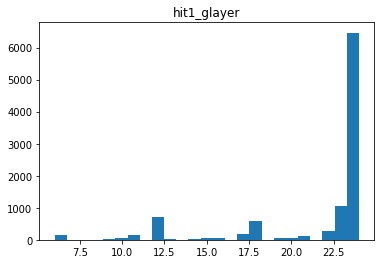

[]

In [ ]:
filter_ignore("hit1_glayer",bins=25)

In [ ]:
csv_train.keys()

### 1D Hist of all Data

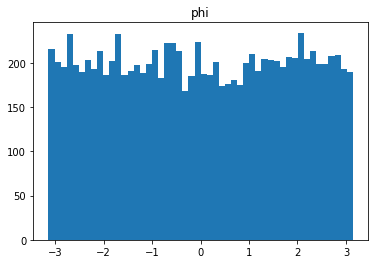

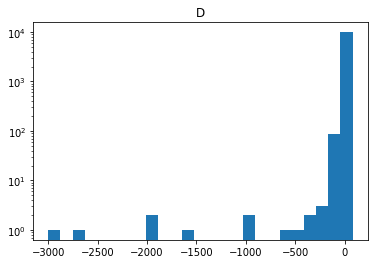

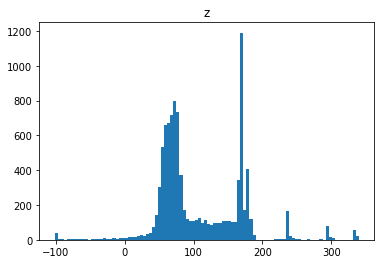

In [ ]:
plt.hist(csv_train["phi"],bins=50) # -3 to 3, even distrib
plt.title("phi")
plt.show()
# ---
plt.hist(csv_train["D"],range=[-3000,80],bins=25) # -3000 to 50, but val in 65
plt.yscale("log")
plt.title("D")
plt.show()
# ---
plt.hist(csv_train["z"],bins=100)
plt.title("z")
plt.show()

In [ ]:
# fig, ax = plt.subplots(2,1,figsize=(5,10))
# fig.subplots_adjust(hspace=0.35)

plt.hist(csv_train["cov_00"],range=[0,1e8],bins=25) # 0 to 1e13
plt.yscale("log")
plt.title("cov_00")
plt.show()
# ---
plt.hist(csv_train["cov_01"],bins=25) # -1e6 to over 1e5
plt.yscale("log")
plt.title("cov_01")
plt.show()
# ---
plt.hist(csv_train["chisq"],bins=25) # 0 to 200
plt.yscale("log")
plt.title("chisq")
plt.show()
# ---
plt.hist(csv_train["Ndof"],range=[0,44],bins=45) # ? this one weird 0 to ~43
plt.yscale("log")
plt.title("Ndof")
plt.show()
# ---
plt.hist(csv_train["rms"],range=[0,0.1],bins=25) # 
# plt.xscale("log")
plt.yscale("log")
plt.title("rms")
plt.show()
# ---
# plt.hist(csv_train["t_start_cntr"],bins=25) # -60 to ~50
plt.hist(csv_train[csv_train["t_start_cntr_valid"] == 1]["t_start_cntr"],bins=25) # -60 to ~50
plt.title("t_start_cntr")
plt.show()

# plt.hist(csv_train["t_tof"],bins=25) # ~-120 to ~175
plt.hist(csv_train[csv_train["t_tof_valid"] == 1]["t_tof"],bins=25) # ~-120 to ~175
plt.title("t_tof")
plt.show()
plt.hist(csv_train["t_bcal"],bins=25) # ~-22 to 20
plt.title("t_bcal")
plt.show()
plt.hist(csv_train["t_fcal"],bins=25) # ~-100 to ~75
plt.yscale("log")
plt.title("t_fcal")
plt.show()
# ---
plt.hist(csv_train["t_start_cntr_valid"],bins=25) # a lot more 0s
plt.title("t_start_cntr_valid")
plt.show()
plt.hist(csv_train["t_tof_valid"],bins=25) # about 5050
plt.title("t_tof_valid")
plt.show()
plt.hist(csv_train["t_bcal_valid"],bins=25) # almost all 0s
plt.title("t_bcal_valid")
plt.show()
plt.hist(csv_train["t_fcal_valid"],bins=25) # almost all 0s
plt.title("t_fcal_valid")
plt.show()
# ---



### 1D Hist of Hit1 Data

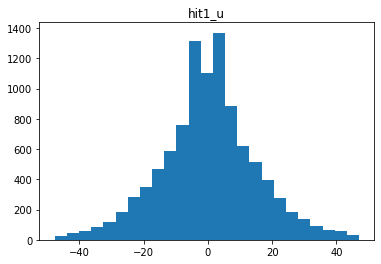

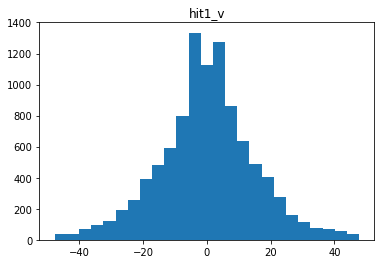

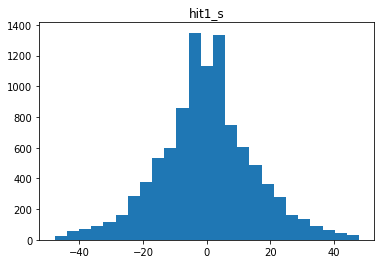

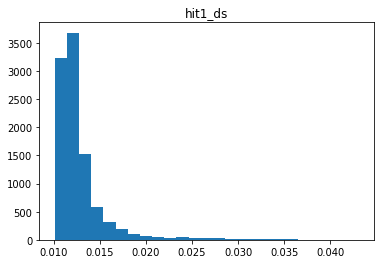

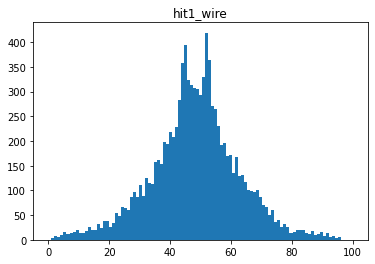

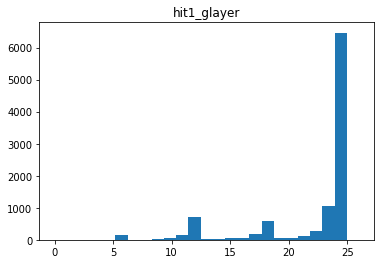

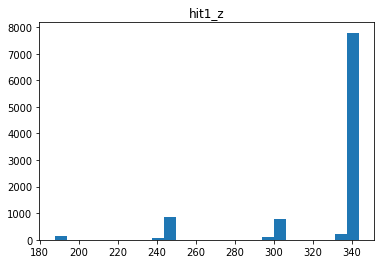

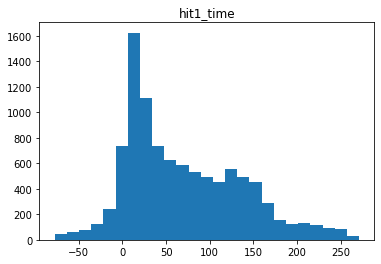

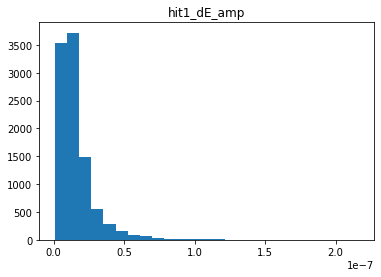

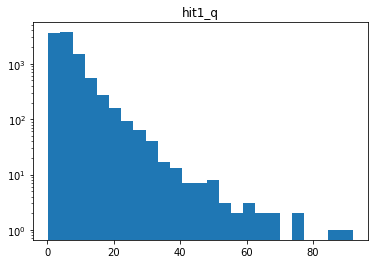

In [ ]:
plt.hist(csv_train["hit1_u"],bins=25) # -42 to 42
plt.title("hit1_u")
plt.show()
plt.hist(csv_train["hit1_v"],bins=25) # -42 to 42
plt.title("hit1_v")
plt.show()
# plt.hist(csv_train["hit1_sinv"],bins=25) # most are 0.96603 almost all are around that though
# plt.title("hit1_sinv")
# plt.show()
# plt.hist(csv_train["hit1_cosv"],bins=25) # most -0.2585
# plt.title("hit1_cosv")
# plt.show()
# plt.hist(csv_train["hit1_sinu"],bins=25) # most 0.96585
# plt.title("hit1_sinu")
# plt.show()
# plt.hist(csv_train["hit1_cosu"],bins=25) # most 0.2591
# plt.title("hit1_cosu")
# plt.show()
plt.hist(csv_train["hit1_s"],bins=25) # -42 to 42
plt.title("hit1_s")
plt.show()
plt.hist(csv_train["hit1_ds"],bins=25) # 0.01 to 0.04
plt.title("hit1_ds")
plt.show()
plt.hist(csv_train["hit1_wire"],bins=101,range=[0,100]) # 0 to 100
plt.title("hit1_wire")
plt.show()
plt.hist(csv_train["hit1_glayer"],bins=25,range=[0,26]) # 6 to 23
plt.title("hit1_glayer")
plt.show()
plt.hist(csv_train["hit1_z"],bins=25) # spaced out between 180 and 340
plt.title("hit1_z")
plt.show()
plt.hist(csv_train["hit1_time"],bins=25) # -75 to 270
plt.title("hit1_time")
plt.show()
plt.hist(csv_train["hit1_dE_amp"],bins=25) # 0 to 2e-7
plt.title("hit1_dE_amp")
plt.show()
plt.hist(csv_train["hit1_q"],bins=25) # 0 to 85
plt.yscale("log")
plt.title("hit1_q")
plt.show()
# ---

### 2D Scatters of various data

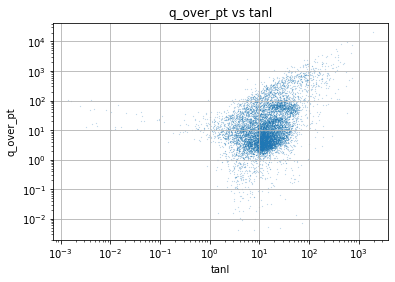

In [ ]:
plt.scatter(csv_train["tanl"],abs(csv_train["q_over_pt"]),s=0.01) # a lot more 0s
plt.title("q_over_pt vs tanl")
plt.xlabel("tanl")
plt.ylabel("q_over_pt")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

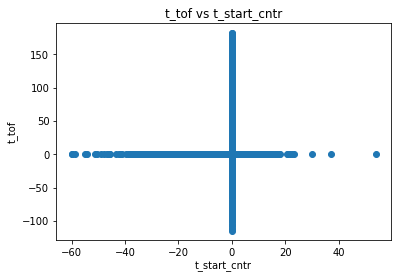

In [ ]:
# all create a plus sign
plt.scatter(csv_train["t_start_cntr"],csv_train["t_tof"]) # a lot more 0s
plt.title("t_tof vs t_start_cntr")
plt.xlabel("t_start_cntr")
plt.ylabel("t_tof")
plt.show()

# plt.hist(csv_train["t_start_cntr"],bins=25) # -60 to ~50
# plt.hist(csv_train["t_tof"],bins=25) # ~-120 to ~175
# plt.hist(csv_train["t_bcal"],bins=25) # ~-22 to 20
# plt.hist(csv_train["t_fcal"],bins=25) # ~-100 to ~75

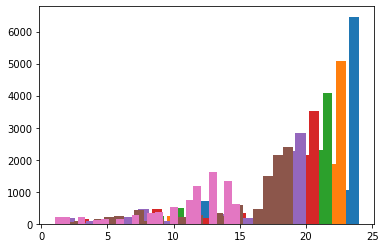

In [ ]:
plt.hist(csv_train["hit1_glayer"],bins=24)
plt.hist(csv_train["hit2_glayer"],bins=24)
plt.hist(csv_train["hit3_glayer"],bins=24)
plt.hist(csv_train["hit4_glayer"],bins=24)
plt.hist(csv_train["hit5_glayer"],bins=24)
plt.hist(csv_train["hit6_glayer"],bins=24)
plt.hist(csv_train["hit10_glayer"],bins=24)
plt.show()

### 2D Scatters of various hit data

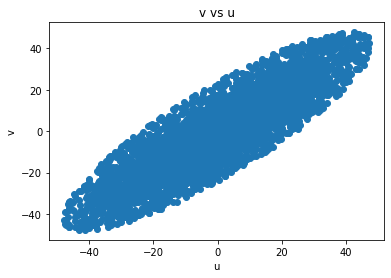

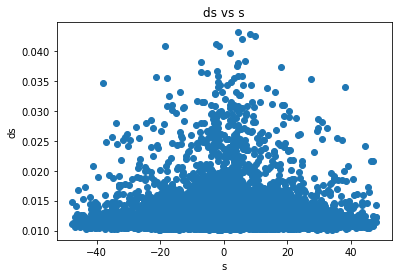

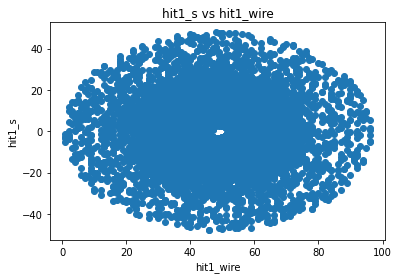

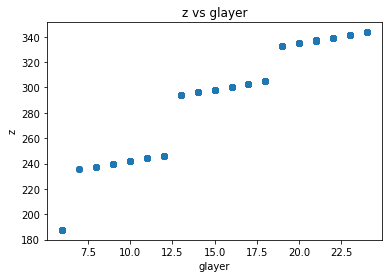

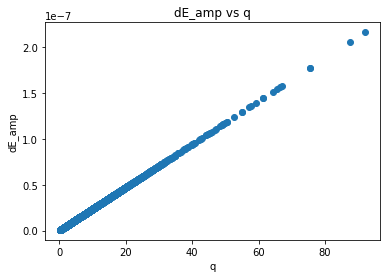

In [ ]:
# Oval
plt.scatter(csv_train["hit1_u"],csv_train["hit1_v"]) # -3 to 3, even distrib
plt.title("v vs u")
plt.xlabel("u")
plt.ylabel("v")
plt.show()

# like a flame
plt.scatter(csv_train["hit1_s"],csv_train["hit1_ds"]) # -3 to 3, even distrib
plt.title("ds vs s")
plt.xlabel("s")
plt.ylabel("ds")
plt.show()

# hit1_wire, with single letters, forms an oval
plt.scatter(csv_train["hit1_wire"],csv_train["hit1_s"]) # -3 to 3, even distrib
plt.title("hit1_s vs hit1_wire")
plt.xlabel("hit1_wire")
plt.ylabel("hit1_s")
plt.show()

# go up in steps
plt.scatter(csv_train["hit1_glayer"],csv_train["hit1_z"]) # -3 to 3, even distrib
plt.title("z vs glayer")
plt.xlabel("glayer")
plt.ylabel("z")
plt.show()

# 1:1
plt.scatter(csv_train["hit1_q"],csv_train["hit1_dE_amp"]) # -3 to 3, even distrib
plt.title("dE_amp vs q")
plt.xlabel("q")
plt.ylabel("dE_amp")
plt.show()



# Model

## Various Models

In [65]:
def model(x):
  x = keras.layers.LSTM(64,activation="tanh", name='input_lstm1', return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'), name="TD1-Dense")(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(14, activation='linear'), name="output-Dense")(x)
  return x
def model_timeless(x):
  x = keras.layers.LSTM(64,activation="tanh", name='input_lstm1', return_sequences=False)(x)
  x = keras.layers.Dense(32, activation='relu', name="Dense1")(x)
  x = keras.layers.Dense(5, activation='relu', name="output-Dense")(x)
  return x

def RNNTime(x):
  x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', stateful=False, return_sequences=True)(x) #, batch_input_shape=(128,None,6)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=False, return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'), name="TD1-Dense")(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(5, activation='linear'), name="output-Dense")(x)
  return x

def RNNTimeless(x):
  # x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', batch_input_shape=() , stateful=False, return_sequences=True)(x) #, batch_input_shape=(128,None,6)
  x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', stateful=False, return_sequences=True)(x) #, batch_input_shape=(128,None,6)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=False, return_sequences=False)(x)
  x = keras.layers.Dense(32, activation='relu', name="Dense1")(x)
  x = keras.layers.Dense(5, activation='linear', name="output-Dense")(x)
  return x

## Build Model

In [66]:
# nInput = 14
# nInput = 10
nInput = 18

inputs = keras.layers.Input((None,nInput))
# print("train shape of one batch:", x_train.shape[1:])

# --==Set seed to get identical results==-- begin
# from tensorflow.random import set_seed
# np.random.seed(1)
# set_seed(2)
# --==Set seed to get identical results==-- end


# --==Choose model==--
# x = model(inputs)
# x = model_timeless(inputs)
x = RNNTime(inputs)
# x = RNNTimeless(inputs)
# x = RNNTimeStateful(inputs)

model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")

## Custom Loss

In [56]:
import tensorflow as tf
import tensorflow.keras.backend as K

#--------------------------------------------
# Define custom loss function 
def customLoss(y_true, y_pred):

  print('y_true shape: ' + str(y_true.shape) )
  print('y_pred shape: ' + str(y_pred.shape) )
  
  batch_size = y_pred.shape[0]
  
  diff = (y_pred - y_true)**2 # will this work?

  # ---How to ID rms from label data?---
  scaled = diff# * rms

  sum = np.sum(scaled,2)

  y_loss = sum/y_pred.shape[-1]

  return y_loss

#--------------------------------------------
# Test loss function
xx = []
yy = []
for i in range(3):
  xx.append(y_train[i])
  yy.append(y_train[i+1])


loss = K.eval(customLoss(K.variable(xx), K.variable(yy)))
print('loss shape: '    + str(loss.shape)    )
print(loss)

y_true shape: (3, 24, 5)
y_pred shape: (3, 24, 5)
loss shape: (3, 24)
[[  37.449   37.449   37.449   37.449   37.449   37.449   37.449   37.449
    37.449   37.449   37.449   37.449   37.449   37.449   37.449   37.449
    37.449   37.449   37.449   37.449   37.449   37.449   37.449   37.449]
 [1468.509 1468.509 1468.509 1468.509 1468.509 1468.509 1468.509 1468.509
  1468.509 1468.509 1468.509 1468.509 1468.509 1468.509 1468.509 1468.509
  1468.509 1468.509 1468.509 1468.509 1468.509 1468.509 1468.509 1468.509]
 [ 235.675  235.675  235.675  235.675  235.675  235.675  235.675  235.675
   235.675  235.675  235.675  235.675  235.675  235.675  235.675  235.675
   235.675  235.675  235.675  235.675  235.675  235.675  235.675  235.675]]


In [59]:
#--------------------------------------------
# Define custom loss function 
def customLoss(y_true, y_pred, rms):

  batch_size = y_pred.shape[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred shape is (batch, 5)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(rms.shape) )  # rms shape is (batch,)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  rms = K.reshape(rms, (batch_size, 1)) # tms  shape is now (batch, 1)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  # rms = tf.transpose(rms, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  y_diff2 = y_diff**2
  scaled = y_diff2 * rms
  sum = np.sum(scaled,2)
  y_loss = scaled/5

  
  # n.b. use "batch_dot" and not "dot"!
  # y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  # y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  # y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  # y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_loss

#--------------------------------------------
# Test loss function
x_test = y_train[0]
y_test = y_train[1]
rms = other_train[0,2]

loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
print('loss shape: '    + str(loss.shape)    )
print(loss)

y_pred shape: (3, 24, 5)
y_true shape: (3, 24, 5)
invcov shape: (3, 25)


InvalidArgumentError: ignored

## Compile Model

In [67]:
# --==Not in use?==--
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.8)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

#--==Set Weights==--
# loss_weights = [1/(sd**2)]
# loss_weights = np.array(loss_weights)/sum(loss_weights)
# model.compile(optimizer=optimizer, loss="mse", loss_weights=loss_weights, metrics=["mae"])

model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

model.summary()

Model: "RNNModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 18)]        0         
_________________________________________________________________
input_lstm1 (LSTM)           (None, None, 128)         75264     
_________________________________________________________________
lstm2 (LSTM)                 (None, None, 64)          49408     
_________________________________________________________________
lstm3 (LSTM)                 (None, None, 32)          12416     
_________________________________________________________________
TD1-Dense (TimeDistributed)  (None, None, 32)          1056      
_________________________________________________________________
output-Dense (TimeDistribute (None, None, 5)           165       
Total params: 138,309
Trainable params: 138,309
Non-trainable params: 0
____________________________________________________

## Fit Model

In [70]:
# es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, shuffle=True, verbose=1, callbacks=[es], validation_data=(x_val, y_val))

# H = model.fit(x=x_train, y=y_train, batch_size=32, epochs=100, validation_split=0.1, shuffle=True, verbose=1)
H = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, shuffle=True, verbose=1)

# H = model.fit(x=x_raggedTensor, y=y_train, batch_size=32, epochs=100, shuffle=True, verbose=1)
# H = model.fit(train_gen, batch_size=1, steps_per_epoch=32, epochs=100, shuffle=True, verbose=1)
# H = model.fit(train_gen, batch_size=32, steps_per_epoch=10000/32, epochs=100, verbose=1)

# Overfit
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=100, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train[:10], y=y_train[:10], batch_size=1, epochs=200, verbose=1, shuffle=True, callbacks=[es])


Epoch 1/100
146/146 [==============================] - 11s 79ms/step - loss: 2323.8992 - mae: 19.6444
Epoch 2/100
146/146 [==============================] - 12s 79ms/step - loss: 2323.8501 - mae: 19.7024
Epoch 3/100
 72/146 [=============>................] - ETA: 5s - loss: 1994.3722 - mae: 19.6522

KeyboardInterrupt: ignored

## Save model

In [ ]:
model.save('first.h5', save_format="h5")

# Test Model

In [69]:
np.set_printoptions(suppress=True, precision=3)
from time import sleep

for i in range(10):
  aax = x_train[i]
  aay = y_train[i]
  aax = np.expand_dims(aax,0)
  aay = np.expand_dims(aay,0)
  pred = model.predict(aax)
  diff = pred - aay
  # print("i: ",i)
  # print("aax:  ",aax[0,0])
  print("pred: ",pred[0])
  # print("aay:  ",aay[0])
  # print("diff: ",diff[0])
  # print("")

  # for i in range(23):
  #   print("aax:  ",aax[0,i,:5])
  #   print("pred: ",pred[0,:5])
  #   print("aay:  ",aay[0,:5])
  #   print("diff: ",diff[0,:5])
  #   print("")


pred:  [[-21.999   0.187  12.956  -0.805  77.392]
 [-27.637   0.24   16.276  -0.99   97.362]
 [-28.502   0.248  16.786  -1.019 100.425]
 [-28.622   0.249  16.857  -1.023 100.851]
 [-28.638   0.249  16.866  -1.023 100.91 ]
 [-28.64    0.249  16.868  -1.024 100.918]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-28.641   0.249  16.868  -1.024 100.919]
 [-2

# Load Model

In [ ]:
model = keras.models.load_model('modelName.h5')

# Graphs

## Graph loss and mae

dict_keys(['loss', 'mae'])
loss:  [2565.33056640625, 686.5439453125, 390.1226501464844, 346.17633056640625, 327.9333190917969, 314.1062927246094, 298.1754455566406, 309.39630126953125, 290.9915771484375, 290.24755859375, 290.7102966308594, 297.9809265136719, 290.7976379394531, 269.4322814941406, 278.294189453125, 266.9839782714844, 279.2789611816406, 258.54827880859375, 251.42567443847656, 262.4107666015625, 255.81402587890625, 264.9518127441406, 255.0871124267578, 256.90655517578125, 251.31753540039062, 247.29437255859375, 235.9088897705078, 249.52786254882812, 251.63201904296875, 256.1289367675781, 242.56993103027344, 246.80833435058594, 249.73707580566406, 244.3120574951172, 247.50234985351562, 236.75741577148438, 240.47117614746094, 240.91732788085938, 238.36746215820312, 234.7778778076172, 241.64776611328125, 242.28102111816406, 245.24073791503906, 245.164306640625, 244.80685424804688, 231.73452758789062, 241.0179901123047, 232.6458740234375, 248.88258361816406, 233.95372009277344

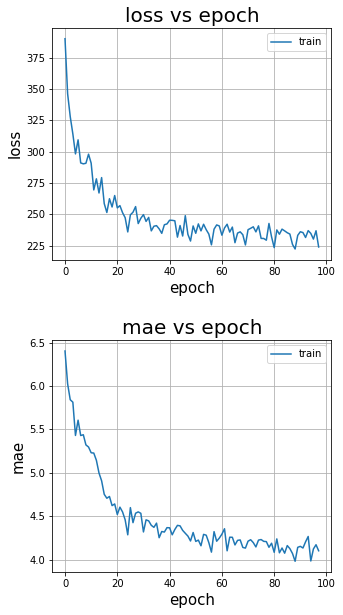

In [ ]:
print(H.history.keys())
print("loss: ", H.history["loss"])
print("mae: ", H.history["mae"])
# print("val_loss: ", H.history["val_loss"])
# print("val_mae: ", H.history["val_mae"])

lim = 2

fig, ax = plt.subplots(2,1,figsize=(5,10))
fig.subplots_adjust(hspace=0.35)

ax[0].plot(H.history["loss"][lim:])
# ax[0].plot(H.history["val_loss"][lim:])
ax[0].set_title("loss vs epoch", fontsize=20)
ax[0].set_xlabel("epoch", fontsize=15)
ax[0].set_ylabel("loss", fontsize=15)
ax[0].legend(["train","val"])
ax[0].grid(True)


ax[1].plot(H.history["mae"][lim:])
# ax[1].plot(H.history["val_mae"][lim:])
ax[1].set_title("mae vs epoch", fontsize=20)
ax[1].set_xlabel("epoch", fontsize=15)
ax[1].set_ylabel("mae", fontsize=15)
ax[1].legend(["train","val"])
ax[1].grid(True)


# Graphs

In [ ]:
# Maybe copy over previous function and edit that?
def graph(pred, true, diff):

  values = ["u","v","sin(v)","cos(v)","sin(u)","cos(u)","s","ds","wire","glayer","z","time","dE_amp","q"]
  limits = [["todo"]]

  size = len(values)

  fig, axs = plt.subplots(4,size,figsize=(size*5,20))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)


  for i in range(size):
    (mu, sigma) = norm.fit(diff[:,i])
    print("data" , values[i] ," |: mu: ", mu, "sigma: " , sigma)
    _, bins, _ = axs[0,i].hist(diff[:,i], 20, density=True)
    y = norm.pdf(bins, mu, sigma)
    l = axs[0,i].plot(bins, y, 'r--', linewidth=2)

    axs[0,i].set_title(values[i] + ' diff')
    axs[0,i].set_ylabel('freq')
    axs[0,i].set_xlabel(values[i] + ' diff')

  #--------------------------------------
  # PREDICTED VS TRUE
  #--------------------------------------
    
  for i in range(size):
    axs[1,i].scatter(true[:,i],pred[:,i])
    axs[1,i].grid(True)

    axs[1,i].set_title(values[i] + ' (predicted vs true)')
    axs[1,i].set_ylabel('pred ' + values[i])
    axs[1,i].set_xlabel('true ' + values[i])

    # axs[1,i].set_xlim(limits[i])
    # axs[1,i].set_ylim(limits[i])
    # axs[1,i].plot(limits[i],limits[i], color='b')

  #--------------------------------------
  # DIFFERENCE VS TRUE
  #--------------------------------------

  for i in range(size):
    axs[2,i].scatter(true[:,i],diff[:,i])
    l, r = axs[2,i].get_xlim()
    axs[2,i].hlines(0, l, r)
    axs[2,i].grid(True)

    axs[2,i].set_title(values[i] + ' (difference vs true)')
    axs[2,i].set_ylabel('diff ' + values[i])
    axs[2,i].set_xlabel('true ' + values[i])

  #--------------------------------------
  # DIFFERENCE VS TRUE 2D HIST
  #--------------------------------------

  for i in range(size):
    axs[3,i].hist2d(true[:,i],diff[:,i],bins=20)

    axs[2,i].set_title(values[i] + ' (difference vs true)')
    axs[2,i].set_ylabel('diff ' + values[i])
    axs[2,i].set_xlabel('true ' + values[i])

  fig.show()


In [ ]:
def gen_test_data(x_test, y_test, size=1000):
  pred = model.predict(x_test)
  diff = pred - y_test
  return pred, y_test, diff

In [ ]:
graph(gen_test_data(x_test, y_test));

# Test model

In [ ]:
# make test function